In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import plotly 
import sklearn
import warnings
warnings.filterwarnings("ignore")

In [46]:
train = pd.read_csv("train.csv",parse_dates = True, index_col = 'Date')



In [47]:
store = pd.read_csv("store.csv")

In [48]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [49]:
train.shape


(1017209, 8)

In [50]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [51]:
store.shape

(1115, 10)

In [52]:
print("train:\n ", train.isnull().sum(),  
     "\nstore:\n", store.isnull().sum())

train:
  Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 
store:
 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [53]:
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval'], axis=1)

Text(0.5, 1.0, 'Distributin of Store Competition Distance')

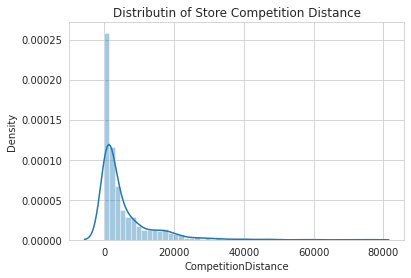

In [54]:
sns.distplot(store.CompetitionDistance.dropna())
plt.title("Distributin of Store Competition Distance")

In [55]:
store.CompetitionDistance.fillna(store.CompetitionDistance.median(), inplace=True)

In [56]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train = train.reset_index()

In [57]:
df = pd.merge(train, store, how='left', on='Store')
df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,0
1,2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,1
2,2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,a,a,14130.0,1
3,2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,c,c,620.0,0
4,2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,a,a,29910.0,0


In [58]:
df1 = df.copy()

In [59]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Date                 1017209 non-null  datetime64[ns]
 1   Store                1017209 non-null  int64         
 2   DayOfWeek            1017209 non-null  int64         
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  object        
 8   SchoolHoliday        1017209 non-null  int64         
 9   Year                 1017209 non-null  int64         
 10  Month                1017209 non-null  int64         
 11  Day                  1017209 non-null  int64         
 12  WeekOfYear           1017209 non-null  int64         
 1

In [60]:
set(df1.StateHoliday), set(df1.StoreType), set(df1.Assortment)

({0, '0', 'a', 'b', 'c'}, {'a', 'b', 'c', 'd'}, {'a', 'b', 'c'})

In [61]:
sales = df1[['Year','Month','Store','Sales']].groupby(['Year','Month','Store']).mean()
sales = sales.rename(columns={'Sales':'AvgSales'})
sales = sales.reset_index()

In [62]:
df1['sales_key']=df1['Year'].map(str) + df1['Month'].map(str) + df1['Store'].map(str)
sales['sales_key']=sales['Year'].map(str) + sales['Month'].map(str) + sales['Store'].map(str)

In [63]:
sales = sales.drop(['Year','Month','Store'], axis=1)

df1 = pd.merge(df1, sales, how='left', on=('sales_key'))

In [64]:
cust = df1[['Year','Month','Store','Customers']].groupby(['Year','Month', 'Store']).mean()
cust = cust.rename(columns={'Customers':'AvgCustomer'})
cust = cust.reset_index()

In [65]:
df1['cust_key']=df1['Year'].map(str) + df1['Month'].map(str) + df1['Store'].map(str)
cust['cust_key']=cust['Year'].map(str) + cust['Month'].map(str) + cust['Store'].map(str)

In [66]:
df1 = df1.drop('Customers', axis=1)
cust = cust.drop(['Year', 'Month', 'Store'], axis=1)
df1 = pd.merge(df1, cust, how="left", on=('cust_key'))

In [67]:
df1['StateHoliday'] = df1.StateHoliday.map({'0':0, 'a':1 ,'b' : 1,'c': 1})

In [68]:
df1 = df1.drop(['cust_key','sales_key','Store','Date'], axis=1)

In [69]:
dfv = df.sample(n=5000, random_state=1)

In [70]:
corr = df1.corr()

Text(0.5, 1.0, 'Correlation Heatmap')

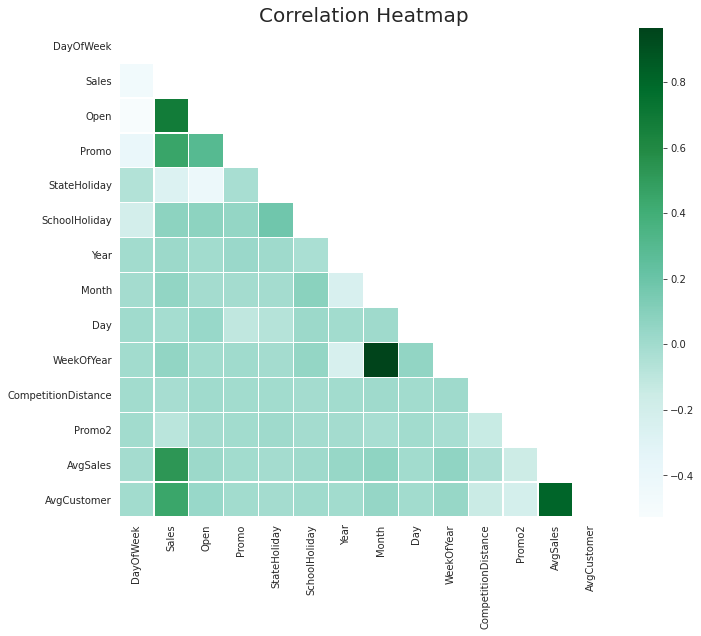

In [73]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(corr, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuGn")
plt.title("Correlation Heatmap", fontsize=20)

In [77]:
dfd = df1.sample(n=50000, random_state=1)

In [104]:
X = dfd.drop('Sales', axis=1)
y = dfd. Sales

In [80]:
xl = X.copy()

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
xl.StateHoliday = label.fit_transform(xl.StateHoliday)
xl.Assortment = label.fit_transform(xl.Assortment)
xl.StoreType = label.fit_transform(xl.StoreType)

In [102]:
from sklearn.model_selection import train_test_split

xl_train,xl_test,yl_train,yl_test = train_test_split(xl,y,test_size=0.3, random_state=1)

In [105]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100  
  
  

In [97]:
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor(n_estimators=30)
rdfreg = rdf.fit(xl_train, yl_train)

In [98]:
print("Regresion Model Score" , ":" , rdfreg.score(xl_train, yl_train) , "," ,
      "Out of Sample Test Score" ,":" , rdfreg.score(xl_test, yl_test))   

yl_predicted = rdfreg.predict(xl_train)
yl_test_predicted = rdfreg.predict(xl_test)

print("Training RMSE", ":", rmse(yl_train, yl_predicted),
      "Testing RMSE", ":", rmse(yl_test, yl_test_predicted))
print("Training MAPE", ":", mape(yl_train, yl_predicted),
      "Testing MAPE", ":", mape(yl_test, yl_test_predicted))

Regresion Model Score : 0.9874815521966153 , Out of Sample Test Score : 0.9166132694977756
Training RMSE : 432.314998936163 Testing RMSE : 1126.5982543848374
Training MAPE : inf Testing MAPE : inf


Text(0.5, 0, 'Relative Importance')

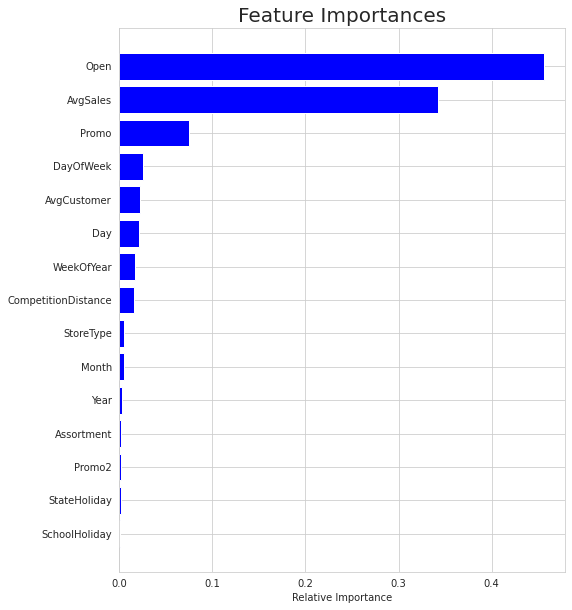

In [100]:
features = xl_train.columns
importances = rdfreg.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,10))
plt.title('Feature Importances', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')